## Initial configuration

### Importing required packages

In [132]:
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet 
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

import xgboost
from joblib import dump, load

import seaborn as sns
import altair as alt
import warnings

In [199]:
import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation, Flatten
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping, History
from keras.regularizers import l1

### Configuring packages

In [4]:
sns.set_style('white')

alt.themes.enable('default')
alt.renderers.enable('kaggle')
alt.renderers.set_embed_options(actions=False)
alt.data_transformers.enable('json')
warnings.filterwarnings("ignore", 'This pattern has match groups')

## Data Loading

### Setting dataset location 

In [5]:
DATA_PATH = Path(r'../input/airbnb')

### Loading data

In [6]:
listings_df = pd.read_csv(DATA_PATH/'listings_summary.csv')
listings_detail_df = pd.read_csv(DATA_PATH/'listings.csv')

reviews_df = pd.read_csv(DATA_PATH/'reviews_summary.csv')
reviews_detail_df = pd.read_csv(DATA_PATH/'reviews.csv')

calendar_df = pd.read_csv(DATA_PATH/'calendar.csv')

neighborhood_df = pd.read_csv(DATA_PATH/'neighbourhoods.csv')
gdf = gpd.read_file(DATA_PATH/'neighbourhoods.geojson')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (61,62,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data Exploration

### listings_summary

#### Data overview

In [7]:
print(f'Number of rows: {listings_df.shape[0]}\nNumber of cols: {listings_df.shape[1]}')
listings_df.sample(3)

Number of rows: 85068
Number of cols: 16


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
46525,25543134,Bright double room with desk,8115623,Naomi,NaN,Enfield,51.60978,-0.11047,Private room,30,2,5,2019-09-23,0.30,2,346
57228,30493556,New Stunning 3 Bedroom House in Heart of London,28820321,Veronica,NaN,Camden,51.53526,-0.14088,Entire home/apt,350,2,4,2019-06-09,0.38,233,0
37287,21587575,Camden Garden Studio * private entrance * en s...,2467762,Jonathan,NaN,Camden,51.54346,-0.13303,Private room,120,3,45,2019-10-23,2.30,4,141


#### Displaying number of nullable records

In [8]:
listings_df.loc[:, listings_df.isnull().sum() > 0].isnull().sum().sort_values(ascending=False)

neighbourhood_group    85068
reviews_per_month      20006
last_review            20006
name                      25
host_name                 12
dtype: int64

#### Displaying number of records without variance (having same value)

In [9]:
listings_df.loc[:, listings_df.nunique() <= 1].nunique().sort_values()

neighbourhood_group    0
dtype: int64

#### Plotting neighbourhood values into chart

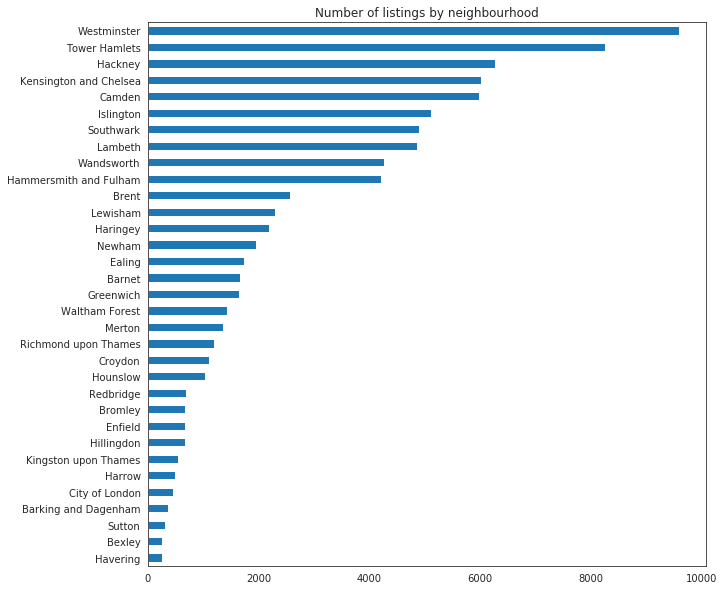

In [10]:
listings_df['neighbourhood'].value_counts().sort_values().plot.barh(figsize=(10, 10));
plt.title('Number of listings by neighbourhood');

#### Plotting room_type values into chart

Text(0.5, 1.0, 'Number of listings by room type')

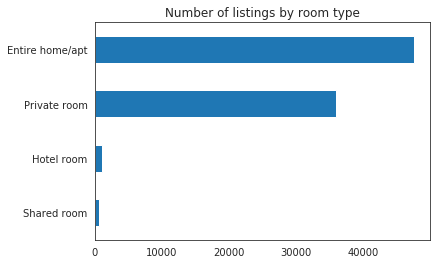

In [11]:
listings_df['room_type'].value_counts().sort_values().plot.barh()
plt.title('Number of listings by room type')

### listings

#### Data overview

In [12]:
print(f'Number of rows: {listings_detail_df.shape[0]}\nNumber of cols: {listings_detail_df.shape[1]}')
listings_detail_df.sample(3)

Number of rows: 85068
Number of cols: 106


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
31617,19589522,https://www.airbnb.com/rooms/19589522,20191105115249,2019-11-05,Spacious Double Room in Hackney / Homerton!,We have a spacious double bedroom available in...,"There are three of us in the flat, we're all s...",We have a spacious double bedroom available in...,none,"Homerton is a lovely, green area with lots of ...",...,t,f,moderate,f,f,2,0,2,0,0.14
7598,6082528,https://www.airbnb.com/rooms/6082528,20191105115249,2019-11-06,Sunny Bedroom in King's Cross,"The flat is very spacious, a large living area...","The Space The Flat is very spacious, furnished...","The flat is very spacious, a large living area...",none,NaN,...,f,f,flexible,f,f,2,1,0,1,NaN
81108,39023778,https://www.airbnb.com/rooms/39023778,20191105115249,2019-11-06,Bamboo Room Mile end,room is 2 mins walk from Bow road station and ...,We would like a clean and tranquil guest.For s...,room is 2 mins walk from Bow road station and ...,none,"Very tranquil, surrounded by green areas.",...,f,f,strict_14_with_grace_period,f,f,2,0,2,0,0.88


#### Displaying number of nullable records

In [13]:
listings_detail_df.loc[:, listings_detail_df.isnull().sum() > 0].isnull().sum().sort_values(ascending=False)

medium_url                      85068
xl_picture_url                  85068
neighbourhood_group_cleansed    85068
host_acceptance_rate            85068
thumbnail_url                   85068
jurisdiction_names              85066
license                         84889
square_feet                     84671
monthly_price                   80103
weekly_price                    78112
notes                           52269
access                          39320
house_rules                     35807
host_about                      35751
interaction                     35286
transit                         30748
neighborhood_overview           30374
security_deposit                29125
host_response_rate              25900
host_response_time              25900
space                           25850
review_scores_checkin           21723
review_scores_value             21722
review_scores_location          21721
review_scores_accuracy          21675
review_scores_communication     21667
review_score

#### Displaying number of records without variance (having same value)

In [14]:
listings_detail_df.loc[:, listings_detail_df.nunique() <= 1].nunique().sort_values()

thumbnail_url                   0
medium_url                      0
xl_picture_url                  0
host_acceptance_rate            0
neighbourhood_group_cleansed    0
scrape_id                       1
has_availability                1
jurisdiction_names              1
is_business_travel_ready        1
dtype: int64

#### Couting number of rows with missing review score (there are 7 columns containing reviews score for different scopes)

In [15]:
listings_detail_df.filter(regex='review_scores').isnull().sum(axis=1).value_counts()

0    63317
7    21616
3       40
4       34
1       23
6       22
5       12
2        4
dtype: int64

### calendar

#### Data overview

In [16]:
print(f'Number of rows: {calendar_df.shape[0]}\nNumber of cols: {calendar_df.shape[1]}')
calendar_df.sample(3)

Number of rows: 31050094
Number of cols: 7


,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
13294518,21344803,2020-01-10,f,$71.00,$71.00,2.0,1125.0
25377226,35665534,2020-02-01,f,$30.00,$30.00,1.0,1125.0
11889285,19885222,2019-11-20,f,$69.00,$69.00,2.0,1125.0


#### Displaying number of nullable records

In [17]:
calendar_df.loc[:, calendar_df.isnull().sum() > 0].isnull().sum().sort_values(ascending=False)

adjusted_price    918
price             918
maximum_nights     10
minimum_nights     10
dtype: int64

### reviews

#### Data overview

In [18]:
print(f'Number of rows: {reviews_df.shape[0]}\nNumber of cols: {reviews_df.shape[1]}')
reviews_df.sample(3)

Number of rows: 1486236
Number of cols: 2


,listing_id,date
1159410,23760987,2018-03-26
645297,13278373,2016-07-13
514191,9701814,2016-09-18


#### Displaying number of nullable records

In [19]:
reviews_df.isnull().sum()

listing_id    0
date          0
dtype: int64

### reviews_summary

#### Data oveview

In [20]:
print(f'Number of rows: {reviews_detail_df.shape[0]}\nNumber of cols: {reviews_detail_df.shape[1]}')
reviews_detail_df.sample(3)

Number of rows: 1486236
Number of cols: 6


,listing_id,id,date,reviewer_id,reviewer_name,comments
1078540,21708467,215709884,2017-12-01,40636547,Alex,Place is great and amazing for all the tourist...
1117419,22559994,259130985,2018-04-30,76204021,Pawel,"Lucy's house is very well located, about 15 mi..."
984678,19965084,238133611,2018-02-25,8910025,Moe,Such a lovely space! Modern Clean and well tho...


#### Displaying number of nullable records

In [21]:
reviews_detail_df.loc[:, reviews_detail_df.isnull().sum() > 0].isnull().sum().sort_values(ascending=False)

comments    622
dtype: int64

### neighbourhoods

#### Data overview

In [22]:
print(f'Number of rows: {neighborhood_df.shape[0]}\nNumber of cols: {neighborhood_df.shape[1]}')
neighborhood_df.sample(3)

Number of rows: 33
Number of cols: 2


,neighbourhood_group,neighbourhood
0,NaN,Barking and Dagenham
23,NaN,Merton
15,NaN,Havering


#### Displaying number of nullable records

In [23]:
neighborhood_df.loc[:, neighborhood_df.isnull().sum() > 0].isnull().sum().sort_values(ascending=False)

neighbourhood_group    33
dtype: int64

### neighbourhoods.geojson

#### Data overview

In [24]:
print(f'Number of rows: {gdf.shape[0]}\nNumber of cols: {gdf.shape[1]}')
gdf.sample(3)

Number of rows: 33
Number of cols: 3


,neighbourhood,neighbourhood_group,geometry
16,Lewisham,None,"MULTIPOLYGON (((-0.03241 51.49305, -0.03240 51..."
18,Bexley,None,"MULTIPOLYGON (((0.12021 51.51145, 0.12159 51.5..."
23,Kensington and Chelsea,None,"MULTIPOLYGON (((-0.18388 51.47742, -0.18403 51..."


#### Displaying number of nullable records

In [25]:
gdf.loc[:, gdf.isnull().sum() > 0].isnull().sum().sort_values(ascending=False)

neighbourhood_group    33
dtype: int64

## Data Cleaning

### Checking country_code to make sure it's from GB

In [26]:
listings_detail_df['country_code'].value_counts()

GB    85065
FR        2
ES        1
Name: country_code, dtype: int64

In [27]:
invalid_ids = listings_detail_df.query('country_code != "GB"')['id']
for invalid_id in invalid_ids:
    listings_detail_df = listings_detail_df[listings_detail_df.id != invalid_id]
    listings_df = listings_df[listings_df.id != invalid_id]
    reviews_df = reviews_df[reviews_df.listing_id != invalid_id]
    reviews_detail_df = reviews_detail_df[reviews_detail_df.listing_id != invalid_id] 
    calendar_df = calendar_df[calendar_df.listing_id != invalid_id]

### Dropping columns containing not useful data and containing texts (e.g. description) because NLP won't be used

In [28]:
df = listings_detail_df

cols_to_drop = ['listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications', 'calendar_last_scraped', 'calendar_updated', 'availability_30', 'availability_60', 'availability_365', 'number_of_reviews_ltm', 'reviews_per_month', 'first_review', 'last_review']
df = df.drop(cols_to_drop, axis=1)

### Setting id as index

In [29]:
df.set_index('id', inplace=True)

### Dropping columns containing mostly null values 

In [30]:
df.isnull().sum().sort_values(ascending = False).head(10)

neighbourhood_group_cleansed    85065
jurisdiction_names              85065
host_acceptance_rate            85065
license                         84886
square_feet                     84668
monthly_price                   80100
weekly_price                    78109
security_deposit                29123
host_response_rate              25897
host_response_time              25897
dtype: int64

In [31]:
df.drop(['host_acceptance_rate', 'neighbourhood_group_cleansed', 'square_feet', 'weekly_price', 'monthly_price', 'license', 'jurisdiction_names', 'experiences_offered'], axis=1, inplace=True)

### Dropping columns cotaining mostly the same values (without variance)

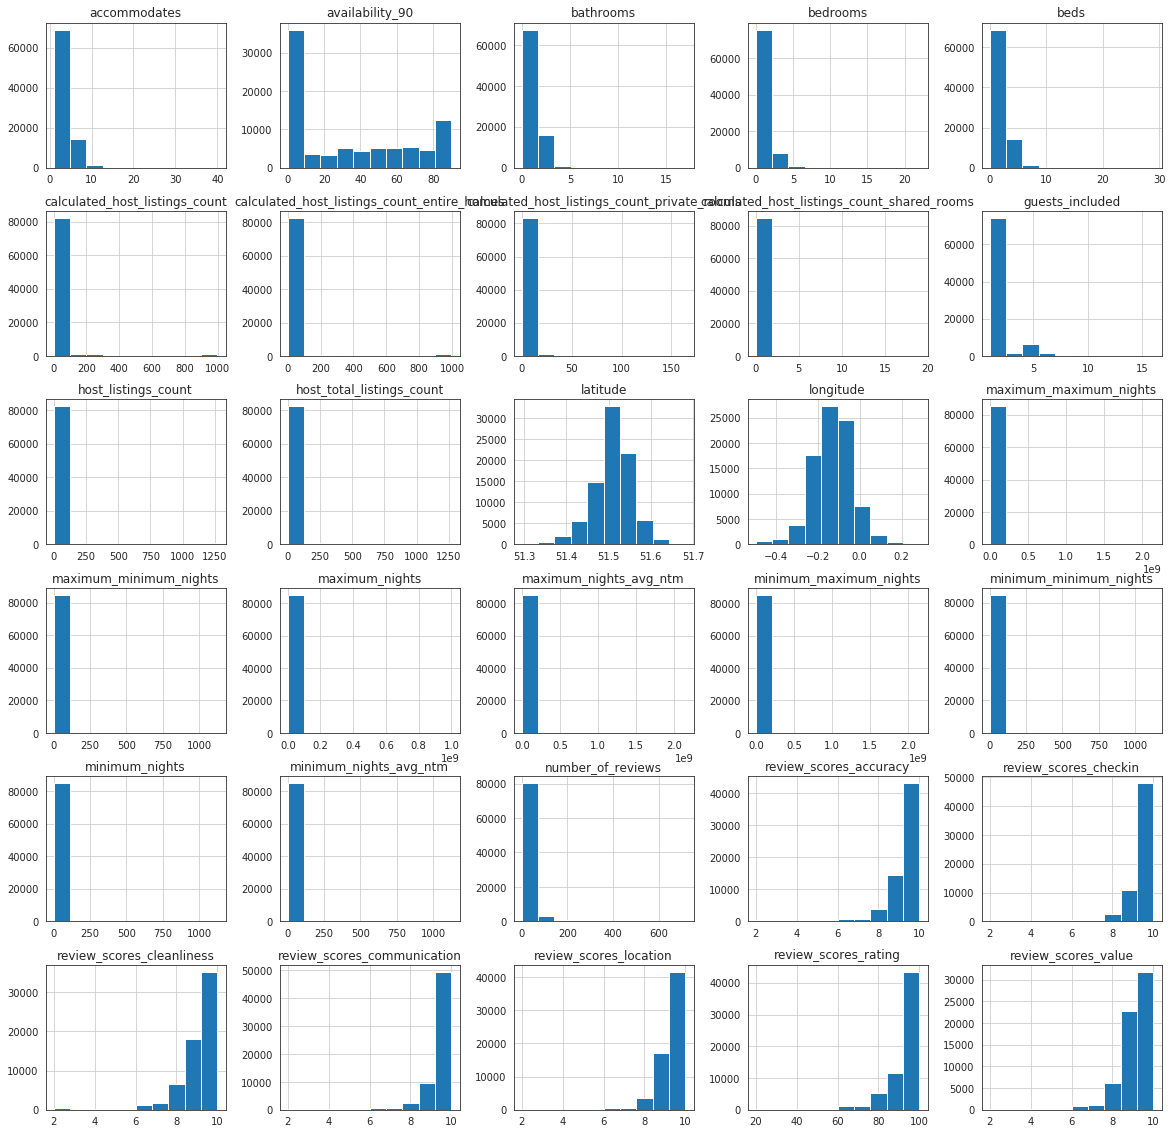

In [32]:
df.hist(figsize=(20,20))
plt.show()

In [33]:
df.drop(['has_availability', 'host_has_profile_pic', 'is_business_travel_ready', 'require_guest_phone_verification', 'require_guest_profile_picture', 'requires_license', 'bed_type'], axis=1, inplace=True)

### Dropping multiple columns that describe host listings count, leaving only host_listings_count

In [34]:
df.drop(['host_total_listings_count', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms'], axis=1, inplace=True)

### Dropping columns describing location, leaving only neighbourhood_cleansed that contains district name

In [35]:
df.drop(['zipcode', 'latitude', 'longitude', 'street', 'neighbourhood', 'city', 'state', 'market', 'smart_location', 'country_code', 'country', 'is_location_exact'], axis=1, inplace=True)

### Dropping columns describing max/min/avr of minimum/maximum number of nights guest has to spend, leaving only minimum_nights and maximum_nigths

In [36]:
df.drop(['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'], axis=1, inplace=True)

### Checking which columns need to be cleaned

In [37]:
df.loc[:, df.isnull().sum() > 0].isnull().sum().sort_values(ascending=False)

security_deposit               29123
host_response_rate             25897
host_response_time             25897
review_scores_checkin          21721
review_scores_value            21720
review_scores_location         21719
review_scores_accuracy         21673
review_scores_communication    21665
review_scores_cleanliness      21659
review_scores_rating           21620
cleaning_fee                   20995
beds                             149
bathrooms                        121
bedrooms                          89
host_identity_verified            12
host_listings_count               12
host_is_superhost                 12
host_since                        12
dtype: int64

### security_deposit

#### Replacing null values

In [38]:
df.security_deposit.fillna('$0.00', inplace=True)

#### Casting values to integer

In [39]:
df.security_deposit = df.security_deposit.str[1:-3]
df.security_deposit = df.security_deposit.str.replace(",", "")
df.security_deposit = df.security_deposit.astype('int64')

### price

#### Looking at data

In [40]:
df['price'].sample(3)

id
6164192     $150.00
35482445    $106.00
19031900    $250.00
Name: price, dtype: object

#### Casting values to integer

In [41]:
df.price = df.price.str[1:-3]
df.price = df.price.str.replace(",", "")
df.price = df.price.astype('int64')

#### Dropping most extreme values

In [42]:
df = df[df.price < np.percentile(df.price, 95)]
df = df[df.price > np.percentile(df.price, 5)]

### cleaning_fee

#### Replacing null values

In [43]:
df.cleaning_fee.fillna('$0.00', inplace=True)

#### Casting values to integer

In [44]:
df.cleaning_fee = df.cleaning_fee.str[1:-3]
df.cleaning_fee = df.cleaning_fee.str.replace(",", "")
df.cleaning_fee = df.cleaning_fee.astype('int64')

### extra_people

#### Replacing null values

In [45]:
df.extra_people.fillna('$0.00', inplace=True)

#### Casting values to integer

In [46]:
df.extra_people = df.extra_people.str[1:-3]
df.extra_people = df.extra_people.str.replace(",", "")
df.extra_people = df.extra_people.astype('int64')

## Host_since

### Finding maximum value

In [47]:
df.sort_values('host_since', ascending=False).head(1)

,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood_cleansed,property_type,room_type,accommodates,...,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy
id,,,,,,,,,,,,,,,,,,,,,
39866251,2019-11-04,NaN,NaN,f,1.0,t,Hammersmith and Fulham,Apartment,Private room,2,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,flexible


### Setting time as host in days

In [48]:
df.host_since = pd.to_datetime(df.host_since) 

# Calculating the number of days
df['days_as_host'] = (pd.datetime(2019, 11, 4) - pd.to_datetime(df.host_since)).dt.days
df.drop('host_since', axis=1, inplace=True)

df.days_as_host.fillna(df.days_as_host.median(), inplace=True)

## host_response_time

### Filling null values with unknown label

In [49]:
df.host_response_time.fillna("unknown", inplace=True)

## host_response_rate

### Removing percentage from string and casting it to float

In [50]:
df.host_response_rate = df.host_response_rate.str[:-1].astype('float64')

### Grouping rates together

In [51]:
df.host_response_rate = pd.cut(df.host_response_rate, bins=[0, 50, 90, 99, 100], labels=['0-49%', '50-89%', '90-99%', '100%'], include_lowest=True)

### Casting to string and replacing null values

In [52]:
df.host_response_rate = df.host_response_rate.astype('str')

df.host_response_rate.replace('nan', 'unknown', inplace=True)

### property_type

#### Looking at data

In [53]:
df.property_type.value_counts()

Apartment                 52328
House                     14694
Condominium                2760
Townhouse                  2553
Serviced apartment         1220
Loft                        698
Bed and breakfast           594
Guest suite                 355
Guesthouse                  290
Other                       169
Boutique hotel              159
Hotel                       142
Bungalow                    122
Cottage                      83
Hostel                       70
Tiny house                   65
Boat                         58
Aparthotel                   48
Houseboat                    31
Villa                        28
Cabin                        17
Camper/RV                    16
Chalet                       12
Earth house                  12
Hut                          10
Casa particular (Cuba)        7
Barn                          6
Farm stay                     5
Yurt                          5
Tent                          4
Campsite                      2
Dome hou

#### Unifying property types

In [54]:
property_map = {
    'Townhouse': 'House',
    'Serviced apartment': 'Apartment',
    'Loft': 'Apartment',
    'Bungalow': 'House',
    'Cottage': 'House',
    'Villa': 'House',
    'Tiny house': 'House',
    'Earth house': 'House',
    'Chalet': 'House'
}
df.property_type.replace(property_map, inplace=True)

#### Unifying other types into one group

In [55]:
df.loc[~df.property_type.isin(['House', 'Apartment']), 'property_type'] = 'Other'

### amenities

#### Creating columns for the most important amenities

In [56]:
df['self_check_in'] = df['amenities'].str.contains('Self check-in', case=False)
df['check_in_24h'] = df['amenities'].str.contains('24-hour check-in', case=False)

df['breakfast'] = df['amenities'].str.contains('Breakfast', case=False)
df['coffee_machine'] = df['amenities'].str.contains('Coffee maker|Espresso machine', case=False)
df['appliances'] = df['amenities'].str.contains('Cooking basics|Dishwasher|Dryer|Washer', case=False)

df['outdoor_space'] = df['amenities'].str.contains('Garden|Outdoor|Sun loungers|Terrace', case=False)

df['tv'] = df['amenities'].str.contains('TV|Television|Telly|TV Set', case=False)
df['internet'] = df['amenities'].str.contains('Internet|Pocket wifi|Wif', case=False)

#### Dropping column

In [57]:
df.drop('amenities', axis=1, inplace=True)

#### Filling null values with 0

In [58]:
amenities_cols = df.iloc[:,31:].columns
df[amenities_cols] = df[amenities_cols].fillna(0)

#### Calculating and dropping amenities that have little to no variance

In [59]:
infrequent_amenities = []
for col in df.iloc[:,31:].columns:
    if df[col].sum() < len(df) / 10:
        infrequent_amenities.append(col)

df.drop(infrequent_amenities, axis=1, inplace=True)

### cancellation_policy

#### Looking at data

In [60]:
df.cancellation_policy.value_counts(normalize = True)

strict_14_with_grace_period    0.427704
flexible                       0.321023
moderate                       0.243268
super_strict_60                0.004022
super_strict_30                0.003879
strict                         0.000104
Name: cancellation_policy, dtype: float64

#### Grouping policies into 3 main avalible on airbnb right now

In [61]:
cancellation_policy_map = {
    'super_strict_30': 'strict_14_with_grace_period',
    'super_strict_60': 'strict_14_with_grace_period',
    'strict': 'strict_14_with_grace_period',
    'luxury_moderate': 'moderate'
}
df.cancellation_policy.replace(cancellation_policy_map, inplace=True)

## Overall

#### Dropping rows containing null values in important columns

In [62]:
df.dropna(subset=['beds'], inplace=True)
df.beds = df.beds.astype('float64')

df.dropna(subset=['bathrooms'], inplace=True)
df.bathrooms = df.bathrooms.astype('float64')

df.dropna(subset=['bedrooms'], inplace=True)
df.bedrooms = df.bedrooms.astype('float64')

df.dropna(subset=['host_listings_count'], inplace=True)
df.host_listings_count = df.host_listings_count.astype('float64')

#### Replacing f/t strings with value

In [63]:
string_boolean_map = {'f': 0, 't': 1}
df.replace(string_boolean_map, inplace=True)

#### Replacing booleans with value

In [64]:
boolean_map = {False: 0, True: 1}
df.replace(boolean_map, inplace=True)

## Data Visualization

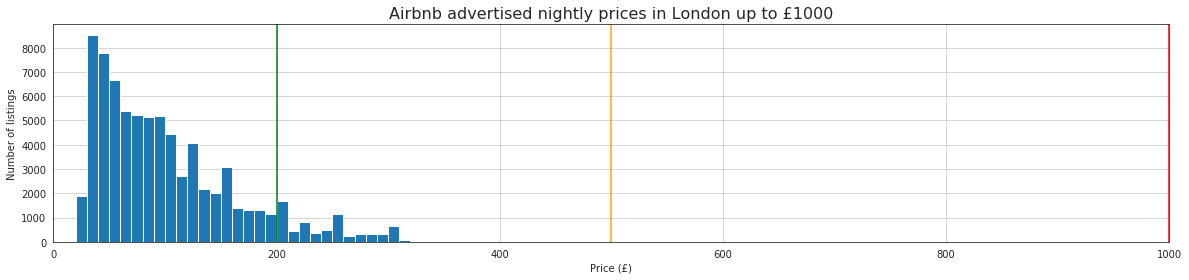

In [65]:
plt.figure(figsize=(20,4))
df.price.hist(bins=100, range=(0,1000))
plt.margins(x=0)
plt.axvline(200, color='green')
plt.axvline(500, color='orange')
plt.axvline(1000, color='red')
plt.title("Airbnb advertised nightly prices in London up to £1000", fontsize=16)
plt.xlabel("Price (£)")
plt.ylabel("Number of listings")
plt.show()

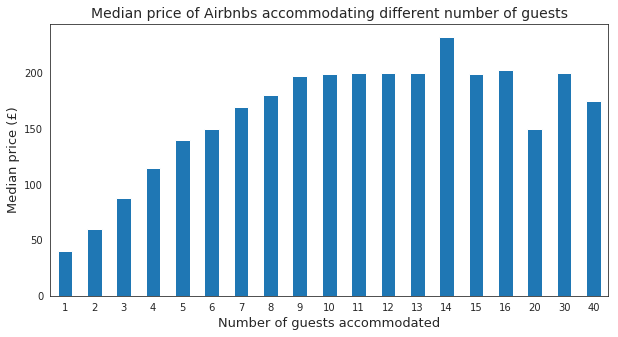

In [66]:
plt.figure(figsize=(10,5))
df.groupby('accommodates').price.median().plot(kind='bar')
plt.title('Median price of Airbnbs accommodating different number of guests', fontsize=14)
plt.xlabel('Number of guests accommodated', fontsize=13)
plt.ylabel('Median price (£)', fontsize=13)
plt.xticks(rotation=0)
plt.show()

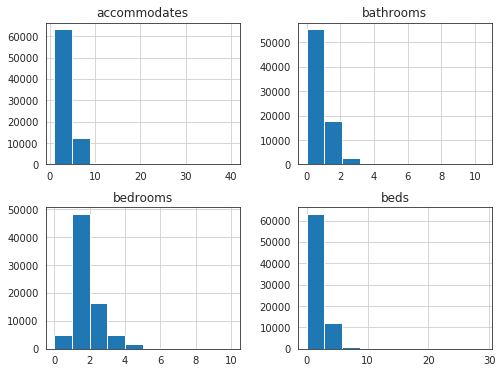

In [67]:
df[['accommodates', 'bathrooms', 'bedrooms', 'beds']].hist(figsize=(8,6));

In [68]:
gdf.drop('neighbourhood_group', axis=1, inplace=True)
gdf.rename(columns={'neighbourhood' : 'neighborhood'}, inplace=True)
gdf = gdf.set_index('neighborhood')

In [69]:
def gen_map_chart(df, review_col, review_title):
    return alt.Chart(df, title=review_title).mark_geoshape().encode(color=f'{review_col}:Q', tooltip=['neighborhood:N', f'{review_col}:Q']).properties(width=250, height=250)

In [70]:
review_cols = ['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']

listing_detail_cols = ['instant_bookable', 'neighbourhood_cleansed', 'room_type'] + review_cols

map_df = df[df.filter(regex='review_scores').notnull().all(axis=1)]
map_df.rename(columns={'neighbourhood_cleansed' : 'neighborhood'}, inplace=True)
map_df.set_index('neighborhood', inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [71]:
geometry_df = gdf.loc[:, ['geometry']]
map_df = geometry_df.join(map_df)

In [72]:
map_df['mean_review_scores_accuracy'] = map_df.groupby('neighborhood')['review_scores_accuracy'].transform('mean')
map_df['mean_review_scores_cleanliness'] = map_df.groupby('neighborhood')['review_scores_cleanliness'].transform('mean')
map_df['mean_review_scores_checkin'] = map_df.groupby('neighborhood')['review_scores_checkin'].transform('mean')
map_df['mean_review_scores_communication'] = map_df.groupby('neighborhood')['review_scores_communication'].transform('mean')
map_df['mean_review_scores_location'] = map_df.groupby('neighborhood')['review_scores_location'].transform('mean')
map_df['mean_review_scores_value'] = map_df.groupby('neighborhood')['review_scores_value'].transform('mean')

map_df['mean_review_scores_all'] = map_df.filter(like='mean_review_scores').mean(axis=1)

In [73]:
map_df['number_of_listings'] = map_df.groupby('neighborhood').size()
median_price_by_neighborhood = map_df.groupby('neighborhood').price.median().values

In [74]:
map_df.reset_index(level=0, inplace=True)

In [75]:
review_cols = ['mean_review_scores_accuracy', 'mean_review_scores_cleanliness', 'mean_review_scores_checkin', 'mean_review_scores_communication', 'mean_review_scores_location', 'mean_review_scores_value']
review_titles = ['Accuracy', 'Cleanliness', 'Check-in', 'Communication', 'Location', 'Value']
review_map = {col: title for col, title in zip(review_cols, review_titles)}

result_df = map_df[['geometry', 'neighborhood', 'mean_review_scores_all', 'number_of_listings'] + review_cols].drop_duplicates()

In [76]:
result_df['median_price'] = median_price_by_neighborhood

In [77]:
review_charts = []

for review_col, review_title in zip(review_cols, review_titles):
    review_charts.append(gen_map_chart(result_df, review_col, review_title))

overall_map_chart = gen_map_chart(result_df, 'mean_review_scores_all', 'Overall')

((alt.vconcat(alt.concat(*review_charts, columns=3), overall_map_chart, 
              title='Average review scores by neighbourhood', 
              center=True)
     .configure_view(strokeWidth=0)
     .configure_title(fontSize=18)
     .configure_legend(title=None, orient='top',  labelFontSize=12)))

alt.VConcatChart(...)

In [78]:
number_of_listings_map_chart = gen_map_chart(result_df, 'number_of_listings', 'Number of listings')

((number_of_listings_map_chart
     .configure_view(strokeWidth=0)
     .configure_title(fontSize=18)
     .configure_legend(title=None, orient='top',  labelFontSize=12)))

alt.Chart(...)

In [79]:
price_map_chart = gen_map_chart(result_df, 'median_price', 'Price median')

((price_map_chart
     .configure_view(strokeWidth=0)
     .configure_title(fontSize=18)
     .configure_legend(title=None, orient='top',  labelFontSize=12)))

alt.Chart(...)

## Modelling

### Replacing hightly correlated review columns with mean from all

In [80]:
review_cols = ['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']

for col in review_cols:
    df[col].fillna(0, inplace=True)

df.review_scores_rating = df[review_cols].mean(axis=1)

df.drop(review_cols, axis=1, inplace=True)

In [81]:
df.rename(columns={'neighbourhood_cleansed': 'borough'}, inplace=True)

In [82]:
transformed_df = pd.get_dummies(df)

In [83]:
# Dropping collinear features
to_drop = ['beds',
           'bedrooms',
           'guests_included', 
           'host_response_rate_unknown',
           'host_response_rate_0-49%',
           'property_type_Apartment',
           'room_type_Private room']
to_drop.extend(list(transformed_df.columns[transformed_df.columns.str.endswith('nan')]))

transformed_df.drop(to_drop, axis=1, inplace=True)

In [84]:
numerical_columns = ['accommodates', 'availability_90', 'bathrooms', 'cleaning_fee', 'extra_people', 'host_days_active', 'host_listings_count', 'maximum_nights', 'minimum_nights', 'number_of_reviews', 'price', 'security_deposit']

In [85]:
# Log transforming columns
numerical_columns = [i for i in numerical_columns if i not in ['availability_90', 'host_days_active']] # Removing items not to be transformed

for col in numerical_columns:
    transformed_df[col] = transformed_df[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    transformed_df[col] = np.log(transformed_df[col])

In [86]:
# Separating X and y
X = transformed_df.drop('price', axis=1)
y = transformed_df.price

# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

In [87]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [88]:
stop

NameError: name 'stop' is not defined

## LinearRegression

In [156]:
param_grid = {
    'fit_intercept':[True,False], 
    'normalize':[True,False], 
    'copy_X':[True, False]
}

#training_scores_encoded = LabelEncoder().fit_transform(y_train)

grid_LinearRegression = GridSearchCV(LinearRegression(), param_grid, scoring='r2', cv=3, n_jobs=-1, return_train_score=True, verbose=1000)

grid_LinearRegression.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to new file /dev/shm/joblib_memmapping_folder_12_9971417869/12-139893168679008-ce9c3c456fae431fb60aaee002b6cf9e.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_9971417869/12-139893168679008-ce9c3c456fae431fb60aaee002b6cf9e.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=in

[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    6.0s
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_9971417869/12-139893168679008-ce9c3c456fae431fb60aaee002b6cf9e.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    6.1s
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_9971417869/12-139893168679008-ce9c3c456fae431fb60aaee002b6cf9e.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickli

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='warn', n_jobs=-1,
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'normalize': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='r2', verbose=1000)

In [157]:
dump(grid_LinearRegression, 'LinearRegression.joblib')

['LinearRegression.joblib']

In [158]:
grid_LinearRegression = load('LinearRegression.joblib')

In [159]:
grid_LinearRegression.best_params_

{'copy_X': True, 'fit_intercept': True, 'normalize': False}

In [160]:
y_pred_train = grid_LinearRegression.predict(X_train)
y_pred_test = grid_LinearRegression.predict(X_test)

In [161]:
LinearRegression_results = pd.DataFrame({
    'algorithm':['LinearRegression'],
    'training_r2_score': [r2_score(y_train, y_pred_train)],
    'test_r2_score': [r2_score(y_test, y_pred_test)]})
LinearRegression_results

,algorithm,training_r2_score,test_r2_score
0,LinearRegression,0.680651,0.677167


## Rigde

In [162]:
param_grid = {'alpha':[0.1, 1, 10, 100, 200, 230, 250, 265, 270, 275, 290, 300, 500]}

grid_Ridge = GridSearchCV(Ridge(), param_grid, cv=3, scoring='r2', n_jobs=-1, return_train_score=True, verbose=1000)

grid_Ridge.fit(X_train, y_train)

Fitting 3 folds for each of 13 candidates, totalling 39 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to new file /dev/shm/joblib_memmapping_folder_12_5123987276/12-139893169412136-d12642ca7861482884a87240a5190784.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_5123987276/12-139893169412136-d12642ca7861482884a87240a5190784.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=i

[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.6s
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_5123987276/12-139893169412136-d12642ca7861482884a87240a5190784.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    3.6s
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_5123987276/12-139893169412136-d12642ca7861482884a87240a5190784.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickli

[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    4.0s
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_5123987276/12-139893169412136-d12642ca7861482884a87240a5190784.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    4.1s
Pickling array (shape=(71,), dtype=object).[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    4.1s

Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_5123987276/12-139893169412136-d12642ca7861482884a87240a5190784.pkl
Pickling array (shape=(71,), dtype

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [0.1, 1, 10, 100, 200, 230, 250, 265, 270,
                                   275, 290, 300, 500]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='r2', verbose=1000)

In [163]:
dump(grid_Ridge, 'Ridge.joblib')

['Ridge.joblib']

In [164]:
grid_Ridge = load('Ridge.joblib')

In [165]:
grid_Ridge.best_params_

{'alpha': 100}

In [166]:
y_pred_train = grid_Ridge.predict(X_train)
y_pred_test = grid_Ridge.predict(X_test)

In [167]:
Ridge_results = pd.DataFrame({
    'algorithm':['Ridge'],
    'training_r2_score': [r2_score(y_train, y_pred_train)],
    'test_r2_score': [r2_score(y_test, y_pred_test)]})
Ridge_results

,algorithm,training_r2_score,test_r2_score
0,Ridge,0.680653,0.677196


## Lasso

In [168]:
param_grid = {'alpha': [1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10]}

grid_Lasso = GridSearchCV(Lasso(), param_grid, scoring='r2', cv=3, n_jobs=-1, return_train_score=True, verbose=1000)

grid_Lasso.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to new file /dev/shm/joblib_memmapping_folder_12_9742952965/12-139893169125192-da6214b183244804aa5f636e72e5e23b.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_9742952965/12-139893169125192-da6214b183244804aa5f636e72e5e23b.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=i

[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   43.1s
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_9742952965/12-139893169125192-da6214b183244804aa5f636e72e5e23b.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   43.1s
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_9742952965/12-139893169125192-da6214b183244804aa5f636e72e5e23b.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickli

[Parallel(n_jobs=-1)]: Done  25 out of  30 | elapsed:   45.8s remaining:    9.2s
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_9742952965/12-139893169125192-da6214b183244804aa5f636e72e5e23b.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done  26 out of  30 | elapsed:   45.8s remaining:    7.0s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   45.9s remaining:    5.1s
[Parallel(n_jobs=-1)]: Done  28 out of  30 | elapsed:   45.9s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   47.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   47.0s finis

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 1e-05, 0.0001, 0.001,
                                   0.01, 1, 5, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='r2', verbose=1000)

In [169]:
dump(grid_Lasso, 'Lasso.joblib')

['Lasso.joblib']

In [170]:
grid_Lasso = load('Lasso.joblib')

In [171]:
grid_Lasso.best_params_

{'alpha': 0.0001}

In [172]:
y_pred_train = grid_Lasso.predict(X_train)
y_pred_test = grid_Lasso.predict(X_test)

In [173]:
Lasso_results = pd.DataFrame({
    'algorithm':['Lasso'],
    'training_r2_score': [r2_score(y_train, y_pred_train)],
    'test_r2_score': [r2_score(y_test, y_pred_test)]})
Lasso_results

,algorithm,training_r2_score,test_r2_score
0,Lasso,0.68065,0.677191


## ElasticNet

In [174]:
param_grid={"max_iter": [1, 5, 10],
            "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
            "l1_ratio": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

grid_ElasticNet = GridSearchCV(ElasticNet(), param_grid, scoring='r2', cv=3, n_jobs=-1, return_train_score=True, verbose=1000)

grid_ElasticNet.fit(X_train, y_train)

Fitting 3 folds for each of 231 candidates, totalling 693 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to new file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype

[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.2s
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    3.2s
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickli

Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    3.9s
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.9s

Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-13989316917

Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    4.4s
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shap

Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    5.1s
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shap

[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:    5.7s
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shap

[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    6.4s
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 101 tasks      | elapsed:    6.4s
Pickling array (shape=(20345,), dtype=int64).
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickli

[Parallel(n_jobs=-1)]: Done 116 tasks      | elapsed:    7.1s
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).[Parallel(n_jobs=-1)]: Done 117 tasks      | elapsed:    7.1s

Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickli

Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:    7.8s
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shap

[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:    8.4s
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 153 tasks      | elapsed:    8.4s
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype

[Parallel(n_jobs=-1)]: Done 169 tasks      | elapsed:    9.1s
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).[Parallel(n_jobs=-1)]: Done 170 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 171 tasks      | elapsed:    9.1s

Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 172 tasks      | elapsed:    9.1s
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca

[Parallel(n_jobs=-1)]: Done 187 tasks      | elapsed:    9.7s
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:    9.8s
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).[Parall

Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:   10.4s
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shap

Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 221 tasks      | elapsed:   11.0s
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 222 tasks      | elapsed:   11.0s
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-13989316917

Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 239 tasks      | elapsed:   11.6s
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (sh

Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:   12.3s
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shap

Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed:   12.9s
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   12.9s
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 610

Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).[Parallel(n_jobs=-1)]: Done 290 tasks      | elapsed:   13.5s

Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).[Parallel(n_jobs=-1)]: Done 291 tasks      | elapsed:   13.6s

Pickli

[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 306 tasks      | elapsed:   14.1s
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 307 tasks      | elapsed:   14.2s
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype

[Parallel(n_jobs=-1)]: Done 323 tasks      | elapsed:   14.8s
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 324 tasks      | elapsed:   14.8s
Pickling array (shape=(20346,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 325 tasks      | elapsed:   14.8s
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype

[Parallel(n_jobs=-1)]: Done 342 tasks      | elapsed:   15.4s
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).[Parallel(n_jobs=-1)]: Done 343 tasks      | elapsed:   15.4s

Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickli

Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
[Parallel(n_jobs=-1)]: Done 362 tasks      | elapsed:   16.0s
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shap

[Parallel(n_jobs=-1)]: Done 381 tasks      | elapsed:   16.7s
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 382 tasks      | elapsed:   16.7s
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickli

[Parallel(n_jobs=-1)]: Done 399 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:   17.3s
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickli

Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 417 tasks      | elapsed:   17.9s
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).[Parallel(n_jobs=-1

Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 437 tasks      | elapsed:   18.5s
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (sh

Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 452 tasks      | elapsed:   19.0s
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shap

Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).[Parallel(n_jobs=-1)]: Done 466 tasks      | elapsed:   19.4s

Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 467 tasks      | elapsed:   19.4s
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickli

Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).[Parallel(n_jobs=-1)]: Done 481 tasks      | elapsed:   19.8s

Pickling array (shape=(20345,), dtype=int64).
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shap

Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:   20.2s

Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca


Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).[Parallel(n_jobs=-1)]: Done 515 tasks      | elapsed:   20.9s

Pickling array (shape=(20345,), dtype=int64).
Pickling array (shape=(71,), dtype=object).[Parallel(n_jobs=-1)]: Done 516 tasks      | elapsed:   20.9s

Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/jobl

Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 529 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 530 tasks      | elapsed:   21.3s
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pi

[Parallel(n_jobs=-1)]: Done 544 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 545 tasks      | elapsed:   21.7s
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickli

[Parallel(n_jobs=-1)]: Done 559 tasks      | elapsed:   22.1s
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:   22.2s
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 561 tasks      | elapsed:   22.2s
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype


Pickling array (shape=(20345,), dtype=int64).
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).[Parallel(n_jobs=-1)]: Done 575 tasks      | elapsed:   22.6s

Pickling array (shape=(20345,), dtype=int64).
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape

Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 589 tasks      | elapsed:   23.0s
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shap

[Parallel(n_jobs=-1)]: Done 605 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 606 tasks      | elapsed:   23.6s
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 607 tasks      | elapsed:   23.6s
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype

Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:   24.0s

Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
[Parallel(n_jobs=-1)

Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 635 tasks      | elapsed:   24.5s
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shap

[Parallel(n_jobs=-1)]: Done 655 tasks      | elapsed:   25.1s
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:   25.1s
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickli

[Parallel(n_jobs=-1)]: Done 669 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 670 tasks      | elapsed:   25.5s
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickli

[Parallel(n_jobs=-1)]: Done 684 tasks      | elapsed:   25.9s
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 685 tasks      | elapsed:   25.9s
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_4342963089/12-139893169175632-6a1b118ca80b443885ecbcebc8dd8b05.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pi

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3068.1315647033443, tolerance: 2.2919221895370723
  positive)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'l1_ratio': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
                                      0.8, 0.9, 1.0],
                         'max_iter': [1, 5, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='r2', verbose=1000)

In [175]:
dump(grid_ElasticNet, 'ElasticNet.joblib')

['ElasticNet.joblib']

In [176]:
grid_ElasticNet = load('ElasticNet.joblib')

In [177]:
grid_ElasticNet.best_params_

{'alpha': 0.0001, 'l1_ratio': 0.8, 'max_iter': 10}

In [178]:
y_pred_train = grid_ElasticNet.predict(X_train)
y_pred_test = grid_ElasticNet.predict(X_test)

In [179]:
ElasticNet_results = pd.DataFrame({
    'algorithm':['ElasticNet'],
    'training_r2_score': [r2_score(y_train, y_pred_train)],
    'test_r2_score': [r2_score(y_test, y_pred_test)]})
ElasticNet_results

,algorithm,training_r2_score,test_r2_score
0,ElasticNet,0.680634,0.67721


## RandomForestRegressor

In [149]:
param_grid={"n_estimators": [1, 5, 10, 20, 30, 40, 50, 100],
            "max_features": ["auto", "sqrt", "log2"],
            "min_samples_split": [2, 4, 8, 16],
            "bootstrap": [True, False],
}

grid_RandomForestRegressor = GridSearchCV(RandomForestRegressor(), param_grid, scoring='r2', cv=3, n_jobs=-1, return_train_score=True, verbose=1000)

grid_RandomForestRegressor.fit(X_train, y_train)

Fitting 3 folds for each of 192 candidates, totalling 576 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to new file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype

[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   29.2s
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   33.1s
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickli

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.1min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.2min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickli

[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:  3.6min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:  3.8min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickli

/opt/conda/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:  4.2min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shap

[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  5.4min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  5.5min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickli

[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:  7.0min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:  7.0min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickli

[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:  8.1min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:  8.2min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickli

[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:  9.2min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
[Parallel(n_jobs=-1)]: Done  99 tasks      | elapsed:  9.2min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickli

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 10.0min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed: 10.0min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickli

[Parallel(n_jobs=-1)]: Done 126 tasks      | elapsed: 10.4min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 127 tasks      | elapsed: 10.4min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickli

[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed: 10.8min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed: 10.8min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickli

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 11.0min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 155 tasks      | elapsed: 11.0min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickli

Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed: 11.3min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 169 tasks      | elapsed: 11.3min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pick

[Parallel(n_jobs=-1)]: Done 182 tasks      | elapsed: 11.5min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 183 tasks      | elapsed: 11.5min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickli

[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 11.8min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed: 11.8min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickli

[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed: 12.1min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 211 tasks      | elapsed: 12.1min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickli

[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed: 12.4min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 225 tasks      | elapsed: 12.4min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickli

[Parallel(n_jobs=-1)]: Done 239 tasks      | elapsed: 12.7min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed: 12.7min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickli

[Parallel(n_jobs=-1)]: Done 253 tasks      | elapsed: 12.9min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 254 tasks      | elapsed: 12.9min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickli

[Parallel(n_jobs=-1)]: Done 267 tasks      | elapsed: 13.1min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed: 13.2min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickli

[Parallel(n_jobs=-1)]: Done 282 tasks      | elapsed: 13.4min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 283 tasks      | elapsed: 13.4min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickli

[Parallel(n_jobs=-1)]: Done 296 tasks      | elapsed: 13.9min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 297 tasks      | elapsed: 13.9min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickli

[Parallel(n_jobs=-1)]: Done 310 tasks      | elapsed: 16.6min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 311 tasks      | elapsed: 16.6min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickli

[Parallel(n_jobs=-1)]: Done 324 tasks      | elapsed: 18.6min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 325 tasks      | elapsed: 18.9min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickli

[Parallel(n_jobs=-1)]: Done 338 tasks      | elapsed: 21.0min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 339 tasks      | elapsed: 21.1min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickli

[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed: 23.2min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 353 tasks      | elapsed: 23.5min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickli

[Parallel(n_jobs=-1)]: Done 366 tasks      | elapsed: 25.3min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 367 tasks      | elapsed: 25.5min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickli

[Parallel(n_jobs=-1)]: Done 380 tasks      | elapsed: 27.7min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 381 tasks      | elapsed: 27.9min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickli

[Parallel(n_jobs=-1)]: Done 394 tasks      | elapsed: 28.6min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 395 tasks      | elapsed: 28.8min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickli

[Parallel(n_jobs=-1)]: Done 408 tasks      | elapsed: 29.5min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 409 tasks      | elapsed: 29.6min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickli

[Parallel(n_jobs=-1)]: Done 422 tasks      | elapsed: 29.9min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 423 tasks      | elapsed: 30.0min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickli

[Parallel(n_jobs=-1)]: Done 436 tasks      | elapsed: 30.4min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 437 tasks      | elapsed: 30.4min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickli

[Parallel(n_jobs=-1)]: Done 450 tasks      | elapsed: 30.8min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 451 tasks      | elapsed: 30.9min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickli

[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed: 31.2min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 465 tasks      | elapsed: 31.2min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickli

[Parallel(n_jobs=-1)]: Done 478 tasks      | elapsed: 31.6min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 479 tasks      | elapsed: 31.6min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickli

[Parallel(n_jobs=-1)]: Done 492 tasks      | elapsed: 31.9min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 493 tasks      | elapsed: 31.9min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickli

[Parallel(n_jobs=-1)]: Done 506 tasks      | elapsed: 32.3min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 507 tasks      | elapsed: 32.4min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickli

[Parallel(n_jobs=-1)]: Done 520 tasks      | elapsed: 32.8min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 521 tasks      | elapsed: 32.8min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickli

[Parallel(n_jobs=-1)]: Done 534 tasks      | elapsed: 33.1min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 535 tasks      | elapsed: 33.2min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickli

[Parallel(n_jobs=-1)]: Done 548 tasks      | elapsed: 33.5min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 549 tasks      | elapsed: 33.5min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickli

[Parallel(n_jobs=-1)]: Done 562 tasks      | elapsed: 33.8min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 563 tasks      | elapsed: 33.8min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_1015579976/12-139893169951408-deb5a48599ec4e208ecbc8523b099eb4.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickli

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'bootstrap': [True, False],
     

In [150]:
dump(grid_RandomForestRegressor, 'RandomForestRegressor.joblib')

['RandomForestRegressor.joblib']

In [151]:
grid_XGBRegressor = load('RandomForestRegressor.joblib')

In [152]:
grid_RandomForestRegressor.best_params_

{'bootstrap': False,
 'max_features': 'sqrt',
 'min_samples_split': 4,
 'n_estimators': 100}

In [154]:
y_pred_train = grid_RandomForestRegressor.predict(X_train)
y_pred_test = grid_RandomForestRegressor.predict(X_test)

In [155]:
RandomForestRegressor_results = pd.DataFrame({
    'algorithm':['RandomForestRegressor'],
    'training_r2_score': [r2_score(y_train, y_pred_train)],
    'test_r2_score': [r2_score(y_test, y_pred_test)]})
RandomForestRegressor_results

,algorithm,training_r2_score,test_r2_score
0,RandomForestRegressor,0.987936,0.745764


## XGBRegressor

In [180]:
XGBRegressor = xgboost.XGBRegressor()
param_grid = {'n_estimators': [100, 150, 200],
              'learning_rate': [0.01, 0.05, 0.1], 
              'max_depth': [3, 4, 5, 6, 7],
              'colsample_bytree': [0.6, 0.7, 1],
              'gamma': [0.0, 0.1, 0.2]}

grid_XGBRegressor = GridSearchCV(XGBRegressor, param_grid, scoring='r2', cv=3, n_jobs=-1, return_train_score=True, verbose=1000)

grid_XGBRegressor.fit(X_train, y_train)

Fitting 3 folds for each of 405 candidates, totalling 1215 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to new file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=

[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   40.6s
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   43.1s
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.9min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.9min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:  3.1min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:  3.4min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  4.3min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:  4.4min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:  5.3min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  5.4min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  6.7min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  6.8min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:  7.9min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:  8.0min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  8.8min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 110 tasks      | elapsed:  8.9min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 123 tasks      | elapsed: 10.1min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 10.3min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 11.5min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 11.6min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed: 12.4min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed: 12.5min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 13.5min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 166 tasks      | elapsed: 13.7min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 179 tasks      | elapsed: 15.1min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed: 15.1min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 193 tasks      | elapsed: 16.0min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed: 16.0min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 207 tasks      | elapsed: 17.1min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed: 17.2min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 222 tasks      | elapsed: 18.7min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 223 tasks      | elapsed: 18.8min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 236 tasks      | elapsed: 19.6min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 237 tasks      | elapsed: 19.7min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 250 tasks      | elapsed: 20.8min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 251 tasks      | elapsed: 20.8min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed: 22.1min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed: 22.3min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed: 23.2min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 279 tasks      | elapsed: 23.3min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed: 24.2min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 293 tasks      | elapsed: 24.3min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 306 tasks      | elapsed: 25.6min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 307 tasks      | elapsed: 25.6min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed: 26.8min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 321 tasks      | elapsed: 26.9min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 334 tasks      | elapsed: 27.7min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 335 tasks      | elapsed: 27.8min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 348 tasks      | elapsed: 29.0min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 29.2min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 362 tasks      | elapsed: 30.5min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 363 tasks      | elapsed: 30.5min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed: 31.3min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 377 tasks      | elapsed: 31.5min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 390 tasks      | elapsed: 32.4min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 391 tasks      | elapsed: 32.7min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 404 tasks      | elapsed: 34.1min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed: 34.1min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed: 35.1min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 419 tasks      | elapsed: 35.1min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 432 tasks      | elapsed: 36.3min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 433 tasks      | elapsed: 36.3min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 37.9min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 447 tasks      | elapsed: 37.9min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 461 tasks      | elapsed: 39.1min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 462 tasks      | elapsed: 39.1min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 475 tasks      | elapsed: 40.4min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 476 tasks      | elapsed: 40.4min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 489 tasks      | elapsed: 41.9min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 490 tasks      | elapsed: 42.1min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 503 tasks      | elapsed: 43.1min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed: 43.2min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 517 tasks      | elapsed: 44.2min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 518 tasks      | elapsed: 44.2min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 531 tasks      | elapsed: 45.7min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 532 tasks      | elapsed: 45.7min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 545 tasks      | elapsed: 47.0min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 546 tasks      | elapsed: 47.2min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 559 tasks      | elapsed: 48.0min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed: 48.1min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 573 tasks      | elapsed: 49.4min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 574 tasks      | elapsed: 49.6min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 587 tasks      | elapsed: 51.0min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed: 51.1min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 601 tasks      | elapsed: 52.0min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 602 tasks      | elapsed: 52.1min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 615 tasks      | elapsed: 53.2min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed: 53.4min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 629 tasks      | elapsed: 54.9min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 630 tasks      | elapsed: 54.9min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 643 tasks      | elapsed: 55.8min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 55.9min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 657 tasks      | elapsed: 57.0min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed: 57.1min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 671 tasks      | elapsed: 58.6min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed: 58.6min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 685 tasks      | elapsed: 59.6min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 686 tasks      | elapsed: 59.7min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 699 tasks      | elapsed: 60.8min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 700 tasks      | elapsed: 61.0min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 713 tasks      | elapsed: 62.2min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 714 tasks      | elapsed: 62.3min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 727 tasks      | elapsed: 63.6min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed: 63.6min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 741 tasks      | elapsed: 64.6min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 742 tasks      | elapsed: 64.7min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 755 tasks      | elapsed: 66.1min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 756 tasks      | elapsed: 66.2min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 769 tasks      | elapsed: 67.5min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 770 tasks      | elapsed: 67.6min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 783 tasks      | elapsed: 68.5min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 68.5min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 797 tasks      | elapsed: 69.8min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 798 tasks      | elapsed: 69.9min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 811 tasks      | elapsed: 71.5min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 812 tasks      | elapsed: 71.5min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 825 tasks      | elapsed: 72.5min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 826 tasks      | elapsed: 72.8min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 839 tasks      | elapsed: 74.1min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 840 tasks      | elapsed: 74.3min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 853 tasks      | elapsed: 76.3min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 854 tasks      | elapsed: 76.4min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 867 tasks      | elapsed: 77.6min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 868 tasks      | elapsed: 77.7min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 881 tasks      | elapsed: 79.3min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 882 tasks      | elapsed: 79.3min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 895 tasks      | elapsed: 81.3min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed: 81.3min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 909 tasks      | elapsed: 82.7min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 910 tasks      | elapsed: 82.7min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 923 tasks      | elapsed: 84.1min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 924 tasks      | elapsed: 84.1min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 937 tasks      | elapsed: 85.9min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 938 tasks      | elapsed: 86.1min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 951 tasks      | elapsed: 87.8min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 952 tasks      | elapsed: 87.9min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 965 tasks      | elapsed: 89.0min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 966 tasks      | elapsed: 89.1min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 979 tasks      | elapsed: 91.0min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 980 tasks      | elapsed: 91.1min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 993 tasks      | elapsed: 92.9min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 994 tasks      | elapsed: 92.9min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling

[Parallel(n_jobs=-1)]: Done 1007 tasks      | elapsed: 94.2min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1008 tasks      | elapsed: 94.2min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickli

[Parallel(n_jobs=-1)]: Done 1021 tasks      | elapsed: 95.9min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1022 tasks      | elapsed: 95.9min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickli

[Parallel(n_jobs=-1)]: Done 1035 tasks      | elapsed: 97.9min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1036 tasks      | elapsed: 98.1min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickli

[Parallel(n_jobs=-1)]: Done 1049 tasks      | elapsed: 99.1min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1050 tasks      | elapsed: 99.2min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickli

[Parallel(n_jobs=-1)]: Done 1063 tasks      | elapsed: 100.7min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1064 tasks      | elapsed: 100.8min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pick

[Parallel(n_jobs=-1)]: Done 1077 tasks      | elapsed: 102.8min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1078 tasks      | elapsed: 103.0min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pick

[Parallel(n_jobs=-1)]: Done 1091 tasks      | elapsed: 104.1min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1092 tasks      | elapsed: 104.2min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pick

[Parallel(n_jobs=-1)]: Done 1105 tasks      | elapsed: 105.8min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1106 tasks      | elapsed: 105.8min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pick

[Parallel(n_jobs=-1)]: Done 1119 tasks      | elapsed: 107.6min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed: 108.0min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pick

[Parallel(n_jobs=-1)]: Done 1133 tasks      | elapsed: 109.3min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1134 tasks      | elapsed: 109.4min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pick

[Parallel(n_jobs=-1)]: Done 1147 tasks      | elapsed: 110.7min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1148 tasks      | elapsed: 110.7min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pick

[Parallel(n_jobs=-1)]: Done 1161 tasks      | elapsed: 112.6min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1162 tasks      | elapsed: 112.6min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pick

[Parallel(n_jobs=-1)]: Done 1175 tasks      | elapsed: 114.4min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40690,), dtype=int64).
Pickling array (shape=(20346,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1176 tasks      | elapsed: 114.4min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pick

[Parallel(n_jobs=-1)]: Done 1189 tasks      | elapsed: 115.6min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1190 tasks      | elapsed: 115.6min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pick

[Parallel(n_jobs=-1)]: Done 1203 tasks      | elapsed: 117.4min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(61036,), dtype=float64).
Pickling array (shape=(61036,), dtype=int64).
Pickling array (shape=(40691,), dtype=int64).
Pickling array (shape=(20345,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 1204 tasks      | elapsed: 117.6min
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Memmapping (shape=(71, 61036), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_12_405782559/12-139893170171240-1bfc9807b87d4d9ebe500bdfc001f61a.pkl
Pickling array (shape=(71,), dtype=object).
Pickling array (shape=(61036,), dtype=int64).
Pick

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:47:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.7, 1],
                         'gamma': [0.0, 0.1, 0.2],
             

In [182]:
dump(grid_XGBRegressor, 'XGBRegressor.joblib')

['XGBRegressor.joblib']

In [183]:
grid_XGBRegressor = load('XGBRegressor.joblib')

[12:51:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [184]:
grid_XGBRegressor.best_params_

{'colsample_bytree': 0.7,
 'gamma': 0.2,
 'learning_rate': 0.1,
 'max_depth': 7,
 'n_estimators': 200}

In [185]:
y_pred_train = grid_XGBRegressor.predict(X_train)
y_pred_test = grid_XGBRegressor.predict(X_test)

In [186]:
XGBRegressor_results = pd.DataFrame({
    'algorithm':['XGBRegressor'],
    'training_r2_score': [r2_score(y_train, y_pred_train)],
    'test_r2_score': [r2_score(y_test, y_pred_test)]})
XGBRegressor_results

,algorithm,training_r2_score,test_r2_score
0,XGBRegressor,0.799417,0.751305


## Deep neural networks

In [187]:
# Building the model
nn2 = Sequential()
nn2.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
nn2.add(Dense(256, activation='relu'))
nn2.add(Dense(256, activation='relu'))
nn2.add(Dense(1, activation='linear'))

# Compiling the model
nn2.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

In [188]:
nn2_history = nn2.fit(X_train,
                  y_train,
                  epochs=100,
                  batch_size=256,
                  validation_split = 0.1)

Train on 54932 samples, validate on 6104 samples
Epoch 1/100
54932/54932 [==============================] - 2s 29us/step - loss: 0.6153 - mean_squared_error: 0.6153 - val_loss: 0.1557 - val_mean_squared_error: 0.1557
Epoch 2/100
54932/54932 [==============================] - 1s 19us/step - loss: 0.1355 - mean_squared_error: 0.1355 - val_loss: 0.1310 - val_mean_squared_error: 0.1310
Epoch 3/100
54932/54932 [==============================] - 1s 19us/step - loss: 0.1194 - mean_squared_error: 0.1194 - val_loss: 0.1230 - val_mean_squared_error: 0.1230
Epoch 4/100
54932/54932 [==============================] - 1s 20us/step - loss: 0.1115 - mean_squared_error: 0.1115 - val_loss: 0.1209 - val_mean_squared_error: 0.1209
Epoch 5/100
54932/54932 [==============================] - 1s 20us/step - loss: 0.1075 - mean_squared_error: 0.1075 - val_loss: 0.1180 - val_mean_squared_error: 0.1180
Epoch 6/100
54932/54932 [==============================] - 1s 19us/step - loss: 0.1043 - mean_squared_error: 0.

54932/54932 [==============================] - 1s 19us/step - loss: 0.0332 - mean_squared_error: 0.0332 - val_loss: 0.1445 - val_mean_squared_error: 0.1445
Epoch 50/100
54932/54932 [==============================] - 1s 19us/step - loss: 0.0327 - mean_squared_error: 0.0327 - val_loss: 0.1460 - val_mean_squared_error: 0.1460
Epoch 51/100
54932/54932 [==============================] - 1s 19us/step - loss: 0.0322 - mean_squared_error: 0.0322 - val_loss: 0.1420 - val_mean_squared_error: 0.1420
Epoch 52/100
54932/54932 [==============================] - 1s 19us/step - loss: 0.0317 - mean_squared_error: 0.0317 - val_loss: 0.1594 - val_mean_squared_error: 0.1594
Epoch 53/100
54932/54932 [==============================] - 1s 19us/step - loss: 0.0320 - mean_squared_error: 0.0320 - val_loss: 0.1424 - val_mean_squared_error: 0.1424
Epoch 54/100
54932/54932 [==============================] - 1s 19us/step - loss: 0.0298 - mean_squared_error: 0.0298 - val_loss: 0.1444 - val_mean_squared_error: 0.1444

54932/54932 [==============================] - 1s 20us/step - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.1522 - val_mean_squared_error: 0.1522
Epoch 98/100
54932/54932 [==============================] - 1s 19us/step - loss: 0.0165 - mean_squared_error: 0.0165 - val_loss: 0.1541 - val_mean_squared_error: 0.1541
Epoch 99/100
54932/54932 [==============================] - 1s 19us/step - loss: 0.0158 - mean_squared_error: 0.0158 - val_loss: 0.1560 - val_mean_squared_error: 0.1560
Epoch 100/100
54932/54932 [==============================] - 1s 19us/step - loss: 0.0159 - mean_squared_error: 0.0159 - val_loss: 0.1575 - val_mean_squared_error: 0.1575


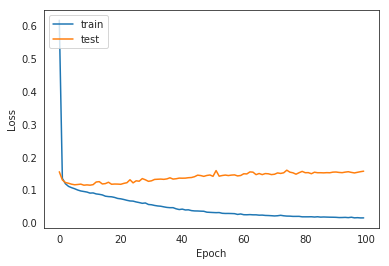

In [193]:
plt.plot(nn2_history.history['loss'])
plt.plot(nn2_history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [196]:
y_pred_train = nn2.predict(X_train)
y_pred_test = nn2.predict(X_test)

In [197]:
DNN_1_results = pd.DataFrame({
    'algorithm':['DNN_1'],
    'training_r2_score': [r2_score(y_train, y_pred_train)],
    'test_r2_score': [r2_score(y_test, y_pred_test)]})
DNN_1_results

,algorithm,training_r2_score,test_r2_score
0,DNN_1,0.919874,0.582919


## Deep neural network 2

In [200]:
nn3 = Sequential()
nn3.add(Dense(128, input_shape=(X_train.shape[1],), kernel_regularizer=l1(0.005), activation='relu'))
nn3.add(Dense(256, kernel_regularizer=l1(0.005), activation='relu'))
nn3.add(Dense(256, kernel_regularizer=l1(0.005), activation='relu'))
nn3.add(Dense(512, kernel_regularizer=l1(0.005), activation='relu'))
nn3.add(Dense(1, activation='linear'))

# Compiling the model
nn3.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

In [ ]:
nn3_history = nn3.fit(X_train,
                  y_train,
                  epochs=150,
                  batch_size=256,
                  validation_split = 0.1)

Train on 54932 samples, validate on 6104 samples
Epoch 1/150
54932/54932 [==============================] - 2s 31us/step - loss: 0.2840 - mean_squared_error: 0.1167 - val_loss: 0.2874 - val_mean_squared_error: 0.1199
Epoch 2/150
54932/54932 [==============================] - 2s 32us/step - loss: 0.2833 - mean_squared_error: 0.1167 - val_loss: 0.2874 - val_mean_squared_error: 0.1208
Epoch 3/150
54932/54932 [==============================] - 2s 31us/step - loss: 0.2824 - mean_squared_error: 0.1165 - val_loss: 0.2866 - val_mean_squared_error: 0.1204
Epoch 4/150
54932/54932 [==============================] - 2s 31us/step - loss: 0.2825 - mean_squared_error: 0.1168 - val_loss: 0.2852 - val_mean_squared_error: 0.1203
Epoch 5/150
54932/54932 [==============================] - 2s 32us/step - loss: 0.2811 - mean_squared_error: 0.1164 - val_loss: 0.2850 - val_mean_squared_error: 0.1209
Epoch 6/150
54932/54932 [==============================] - 2s 32us/step - loss: 0.2812 - mean_squared_error: 0.

In [ ]:
plt.plot(nn3_history.history['loss'])
plt.plot(nn3_history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_pred_train = nn3.predict(X_train)
y_pred_test = nn3.predict(X_test)

In [ ]:
DNN_2_results = pd.DataFrame({
    'algorithm':['DNN_2'],
    'training_r2_score': [r2_score(y_train, y_pred_train)],
    'test_r2_score': [r2_score(y_test, y_pred_test)]})
DNN_2_results